# Задача 2. Линейная регрессия, метод градиентного спуска

* **Дедлайн**: 31.10.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [x] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data
/car_price) (целевой признак для предсказания – **price**).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- [x] При обучении моделей использовать **масштабирование данных**.
- [x] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [x] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- [ ] Повторить тоже самое, но используя **кросс-валидацию**.
- [ ] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k – количество фолдов в кросс-валидации, **E** – мат. ожидание и **STD** – стандартное отклонение. Сделать выводы.
- [ ] \* (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- [ ] \* (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [ ] \* (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- [ ] \* (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.


In [1]:
# type hints impots
from collections.abc import Callable
from numpy.typing import NDArray

# third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# initialize Numpy random `Generator`:
rng = np.random.default_rng(seed=42)

### Предисловие

Честно говоря, я слишком увлекся написанием формул и реализацией алгортима градиентного спуска, и совсем забыл про дедлайны, поэтому первая часть этого ноутбука будет очень подробной и насыщенной, чего не скажешь о финальных частях, где идет сравнение с другими моделями.
Вообще это задание недоделано и я планирую доделать его в ближайшем будущем.

# Градиентный спуск и линейная регрессия

Рассмотрим, в самом простом случае, линейная регрессия будет представлять из себя прямую:

$$ y = kx + b $$

Мы можем записать линейную регрессию в более общем виде, когда число факторов (количество "иксов") равняется $n$:

$$ y = w_0 + w_1x_1 + w_2x_2 + \ldots + w_nx_n $$

Для удобства обозначим $y$ как $\hat{y}$, чтобы дальше не запутаться в обозначениях, а $w_0$ как $b$, так как этот коэффициент не стоит перед иксами и его удобно считать отдельно. Выражение примет вид:

$$ \hat{y} = b + w_1x_1 + w_2x_2 + \ldots + w_nx_n $$


Задача машинного обучения сводится к **минимизации функции потерь**.

Величину ошибки алгоритма $a$ для любого объекта $x \in X$ будем считать как 
$$L(a, x) = (a(x) - y(x))^2,$$ где $y(x)$ - целевая функция, которую мы хотим приближать с помощью алгоритма $a(x)$.

Для нашей модели, линейной регрессии, величина ошибки будет считаться как:
$$L(\hat{y}, x) = (\hat{y}(x) - y(x))^2$$

Для какого-то набора данных $X$ размером $|X| = m$, **средняя квадратичная ошибка** нашего алгоритма будет равна:

$$MSE = \frac{1}{m}\sum{L(\hat{y}(x), x)} = \frac{1}{l}\sum_{x \in X}{\left[\hat{y}(x) - y(x)\right]^2}$$ 

<br>
Чтобы минимизировать функцию потерь $MSE$, нужно подобрать такие значение весов $w = \{w_1, w_2, \dots, w_n\}$ и $b$, чтобы значение $\hat{y}(x)$ было максимально близко к целевой функции $y(x)$ на всем множестве объектов $X$.


Идея градиентного спуска в том, что мы итеративно смещаем значение параметров модели в направлении антиградиента функции потерь. 
Представим, что выборка состоит из одного объекта $x = {x_1, x_2, \dots, x_3}$ с соответсвующим значением $y$, тогда производная функции потерь по коэффициенту $w_k$ будет равна:

$$ \frac{\partial L}{\partial w_k} = 2 (\hat{y}(x) - y)(\hat{y}(x) - y)'_{w_k}$$
$$ = 2(\hat{y}(x) - y)(\hat{y}'_{w_k}(x) - 0)$$
$$ = 2(\hat{y}(x) - y)(b + w_1x_1 + w_2x_2 + \dots + w_kx_k + \dots + w_nx_n)'_{w_k}$$
$$ = 2(\hat{y}(x) - y)x_k,$$

где $k \in \{1, 2, \dots, n\}$ 

Выражение $(\hat{y}(x) - y)$ обозначим как $E$. Итого получаем

$$ \frac{\partial L}{\partial w_k} = 2Ex_k$$

Похожие рассуждения можно провести и для $b$:

$$ \frac{\partial L}{\partial b} = 2(\hat{y}(x) - y)\cdot 1 = 2E$$

Зная разницу между предсказанным и истинным значением целевой функции $E = (\hat{y}(x) - y)$, а также значения признаков $\{x_1, x_2, ...\}$ объекта $x$, можно вычислить частную производную для любого коэффициента модели. Это значит, что можно получить и n-мерный вектор частных производных, то есть **градиент функции**:

$$\nabla{L} = \left(2E, 2Ex_1, 2Ex_2, \ldots, 2Ex_n \right) = 2E \times \left(1, x_1, x_2, \ldots, x_n \right) $$

Напомню, каждый шаг алгоритма должен сдвигать параметры модели в направлении антиградиента, то есть градиента со знаком минус ($-\nabla{L}$)

Поэтому обновление параметров (весов) модели на **одном шаге** градиентного спуска для выборки размера $|X| = m$ будет выглядеть таким образом:

$$w_k := w_k - \frac{\eta}{m} \sum_{x \in X}{\frac{\partial L}{\partial w_k}} 
= w_k - \frac{2 \eta}{m} \sum_{x \in X}{Ex_k}$$
<!-- = w_k - \frac{2 \eta L}{m} \sum_{x \in X}{x_k} -->

$$b := b - \frac{\eta}{m} \sum_{x \in X}{\frac{\partial E}{\partial b}} 
= b - \frac{2 \eta}{m} \sum_{x \in X}{E}
$$
<!-- = b - \frac{2 \eta L}{m} \sum_{x \in X}{1} -->
<!-- = b - {2 \eta L},$$ -->

где $\eta$ – скорость обучения (learning rate) – *гиперпараметр*, который задается пользователем. 
Замечу, что можно не учитывать константу $2$, так как она просто изменяет скорость обучения, которая и так регулируется гиперпараметром $\eta$


Классическая реализация *Стохастического градиентного спуска* (распространенной модификации алгоритма градиентного спуска) предполагает, что градиенты вычисляются по выборкам размера $m = 1$. То есть на каждом шаге алгоритма веса обновляются за счет *одного* тренировочного примера. 

В другой, не менее распространенной модификации градиентного спуска, *Мини-пакетном градиентном спуске* (*Mini-batch Gradient Descent*), градиент считается на каком-то случайном *подмножестве* данных $X_{batch}$, например, размером $|X_{batch}| = m = 32$. Таким образом, мини-пакетный градиентный спуск является компромиссом между обучением на всех примерах сразу и использованием только одного.

$X_{batch} \subset X, |X_{batch}| \le |X|$ 

Нетрудно заметить, что в случае $|X_{batch}| = |X|$ мы получаем в точности оригинальный градиентный спуск, а в случае $|X_{batch}| = 1$ обучение происходит на одном примере, что является определением классического стохастического градиентного спуска. 
Поэтому есть небольшая путаница в понятиях, и зачастую, когда говорят о *стохастическом* градиентном спуске, на самом деле имеют ввиду *мини-пакетный* и наоборот. 

Итого получаем формулы обновлений весов на одном шаге градиентного спуска:

$$
\begin{align}
\qquad \qquad \qquad
&w_k := w_k - \frac{\eta}{m} \sum_{x \in X_{batch}}{Ex_k}, \quad \quad  k = \{1, 2, \dots, n\} 
\\ \\
&b := b - \frac{\eta}{m} \sum_{x \in X_{batch}}{E}
\end{align}
$$

где $n$ – число факторов линейной регрессии, а $m$ – размер "батча".

#### L-2 регуляризация

В машинном обучении моделям свойственно *переобучаться*, поэтому был придуман такой трюк как регуляризация. 
В нашем случае речь пойдет про *L2-регуляризациию*.
Идея в том, что мы стремится сократить влияние отдельных коэффициентов модели, добавляя к функции потерь ещё одно слогаемое: сумма квадратов значений весов модели. 


$$
L = MSE + \frac{\lambda}{2} \sum_{k=1}^n w_k^2
$$

где $\lambda$ – коэффициент регуляризации.  
Чем больше значение $\lambda$, тем сильнее модель штрафуется за большие значения весов.
Замечу, что модель не штрафуется за значения коэффициента $b$. 

Знакомая двойка в знаменателе удобна при нахождении производной, так как мы имеем дело с квадратами. 

Помня,что производная суммы $(u + v)'$ есть сумма производных $u' + v'$, можем сразу переписать формулы обновлений весов на одном шаге градиентного спуска с учетом L2-регуляризации:

$$
\begin{align}
\qquad \qquad \qquad
&w_k := w_k - \eta \left( \frac{1}{m} \sum_{x \in X_{batch}}{Ex_k} + \lambda w_k \right), \quad  k = \{1, 2, \dots, n\} 
\\ \\
&b := b - \eta \cdot \frac{1}{m} \sum_{x \in X_{batch}}{E}
\end{align}
$$

где $n$ – число факторов линейной регрессии, а $m$ – размер "батча".

---

Для начала определим класс модели линейной регрессии `LinearRegression`.

При инициализации объекта будем задачать количество факторов модели , а также начальные веса, если это требуется.

Сами вычисления будут происходить в методе `forward(X)`.

Для удобства я также реализовал *магический* метод `__call__(X)`, который является оберткой над `forward` и позволяет выполнять модель, "вызывая" её объект. Приведу пример:

```Python
linear_reg = LinearRegression()
X = np.random.uniform(size=10)

model_output = linear_reg(X) # using __call__ method to implicitly execute forward 
```

Также замечу, что если не указывать веса модели при инициализации, то они сгенерируются автоматически.

In [2]:
class LinearRegression:
    """
    Linear regression model for predicting a target variable 
    based on a set of input features.

    Methods:
        __init__(n_factors=1, weights=None, bias=None):
            Initializes the model with the specified number of features, weights,
            and bias. If weights or bias are not provided, they are randomly initialized.
        
        forward(X):
            Computes the model output (prediction) given an input matrix `X`.
            Returns a linear combination of `X` and model weights plus the bias.

        __call__(X):
            Convenient way to call the `.forward(X)` method.
        
    Usage Example:
        model = LinearRegression(n_factors=3)
        predictions = model.forward(X)
    """
    # faster attribute access via python 'slots'
    __slots__ = ("_n_factors", "_weights", "_bias")
    def __init__(
        self,
        n_fractors=1, 
        weights: NDArray = None, 
        bias: float = None
    ) -> None:
        self._n_factors = n_fractors
        if weights is None:
            # initialize model with randow weights
            self._weights = rng.standard_normal(size=n_fractors)
        else:
            self._weights = weights
        self._weights.reshape(1, -1)
        if bias is None:
            self._bias = rng.standard_normal()
        else:
            self._bias = bias

    def forward(self, X):
        if len(X.shape) < 2:
            X = X.reshape(-1, 1)
        return np.sum(X * self._weights, axis=1) + self._bias

    def __call__(self, X):
        return self.forward(X)

#### Реализация класса градиентного спуска. 

Название класса `MBGradientDescent` это сокращение от *Mini-batch gradient descent*. 

Ранее было сказано, что обычный, стохастический и мини-пакетный градиентные спуски отичаются размером выборки, 
на которой считаются градиенты для обновления весов. 

Поэтому для всех реализаций ГС используется один общий класс, с той разницей, что для разных релизаций будет подаваться разный размер батчей.

При инициализации класса, можно задать гиперпараметры:
- `lr` - скорость обучения, *Learning Rate*
- `l2_reg_penalty` - коэффициент влияния L2 регуляризации на функцию потерь

Один шаг градиентного спуска вычисляется в методе `step(self, X_batch, y_batch`, на вход которого подается выборка данных. Выборка может состоять как из всех данных, так и из одного элемента.

In [3]:
class MBGradientDescent:
    def __init__(
        self,
        model: LinearRegression,
        loss_fun: Callable,
        lr: float,
        l2_reg_penalty: float = 0.0,
    ) -> None: 
        self._loss = loss_fun
        self._lr = lr
        self._model = model
        self._l2_coef = l2_reg_penalty
        self._n_steps = 0

    def loss(self, y_pred, y_target):
        """Compute loss function with L2-regularization""" 
        return self._loss(y_pred, y_target) + self._l2_coef * np.sum(self._model._weights ** 2)

    def step(self, X_batch, y_batch):
        """
        Make one step of GD
        
        args:
        X_batch -> (BATCH_SIZE, N_FACTORS)
        y_batch -> (BATCH_SIZE, 1)
        """
        y_batch_pred = self._model.forward(X_batch).reshape(-1, 1)
        error = (y_batch_pred - y_batch.reshape(-1, 1))
        self._model._weights -= self._lr * np.mean(error * X_batch, axis=0) 
        self._model._bias -= self._lr * np.mean(error) 
        self._n_steps += 1

    def reset(self):
        self._n_steps = 0

    @property
    def steps(self):
        return self._n_steps

Функция потерь:

In [4]:
def mse_loss(y_pred, y_target):
    return np.mean((y_pred - y_target) ** 2)

Некоторые вспомогательные функции:
1. `shuffle_dataset` для перемешивания датасета
2. `split_dataset` для разделения датасета на тренировочную, тестовую и валидационную выборку
3. `preprocess_data` объединение двух предыдщущих функций. Параметр `test_split` указывает на то, какая часть данных будет использоваться как тестовая выборка, а `val_split` - какая часть данных будет использоваться как валидационная выборка

In [5]:
def shuffle_dataset(X, y):
    """Return a shuffled copy of (X, y) pairs"""
    X = X.copy() # making a copy for preserving an original dataset
    y = y.copy()
    swaps = rng.integers(0, len(X), size=len(X))
    for i, s in enumerate(swaps):
        X[i], X[s] = X[s], X[i]
        y[i], y[s] = y[s], y[i]
    return X, y

def split_dataset(X, y, test_ratio=0.1, val_ratio = 0.1):
    """Splits the dataset into training, validation 
    and testing samples based on the given ratio.
    
    For example, if `len(X) = 100`, `test_ratio = 0.1`, and `val_ratio = 0.1`,
    then `len(X_train) = 80`, `len(X_val) = 10`, and `len(X_test) = 10`.
    
    Returns:
        X_train, X_test, X_val, y_train, y_test, y_val
    """
    vp = int(len(X) * val_ratio) # validation split end pos
    tp = vp + int(len(X) * (test_ratio)) # test split end pos
    return X[tp:], X[vp:tp], X[:vp], y[tp:], y[vp:tp], y[:vp]

def preprocess_data(X, y,test_split = 0.1, val_split=0.1,):
    """Split and shuffle given dataset

    Returns:
        X_train, X_test, X_val, y_train, y_test, y_val
    """
    X, y = shuffle_dataset(X, y)
    return split_dataset(X, y, test_split, val_split)

Наконец реализация функции **gradient_descent(X, y)**.

Я сделал два обязательных параметра `X`, `y`, а остальные параметры опциональными, чтобы функция соотносилась с заданием.

Можно задать несколько параметров:
- `X`, `y`, `X_test`, `y_test`, `X_val`, `y_val` - тренировочные, тестовые и валидационные выборки соотственно.
- `epochs` количество эпох, которое равно количеству шагов градиентного спуска, так как за один раз мы считаем градиент на всех данных. 
- `learning_rate` - скорость обучения
- `loss_fun=mse_loss` - функция потерь (на самом деле, здесь возможна только mse_loss, так как `MBGradientDescent` только по ней, но в будущем можно модифицировать алгоритм, чтобы использовать другие фукнции потерб)
- `l2_reg_penalty` = 0.1 - коэффициент влияния L2 регуляризации
- `verbose`: может быть 0, 1 или 2; регулирует количество информации, которая печатается на экран (в std) во время обучения  
- `print_n_epochs` - число эпох, кратное которому, будет печататься инфомация о значених функии потерь. Работает только если `verbose = 1`.

Звездочка `*`, которая отделяет параметры (X, y), требует от пользователя использовать keyword параметры, то есть явно указывать их имя.  

In [6]:
def gradient_descent(
        X: NDArray, 
        y: NDArray, 
        *,
        X_test=None,
        y_test=None,
        X_val=None,
        y_val=None,
        epochs: int = 100, 
        learning_rate: float = 1e-4,
        loss_fun=mse_loss,
        l2_reg_penalty = 0.1,
        verbose=1,
        print_n_epochs=10
    ):
    """Finds linear regression weights using the classical Gradient Descent algorithm.

    Returns: 
        (weights, bias)
    """
    # setting up empty test sets if it's not specified
    # if validation set is not specified then the test set is used
    if X_test is None:
        X_test, y_test = np.array([]), np.array([])
    if X_val is None:
        X_val, y_val = X_test, y_test

    # prepare model
    n_factors = X.shape[1] # get size of sample features
    model = LinearRegression(n_factors)
    optimizer = MBGradientDescent(
        model=model, 
        loss_fun=loss_fun,
        lr=learning_rate
    )

    if verbose >= 1:
        print(f"Initial weights of the model: {model._weights}, bias:{model._bias}")
        print(f"Dataset size: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
        print(f"{learning_rate=}, {epochs=}")
    
    for i in range(epochs):
        # batch is full train dataset here
        optimizer.step(X_train, y_train)
        
        train_loss = optimizer.loss(model(X_train), y_train)
        val_loss = optimizer.loss(model(X_val), y_val)

        # print training stats
        if verbose > 1:
            print(f"{model._weights=}, {model._bias=}")
            print(f'Epoch {i}: train loss: {train_loss}, val. loss: {val_loss}')
        elif verbose == 1 and i % print_n_epochs == 0:
            print(f'Epoch {i}: train loss: {train_loss}, val. loss: {val_loss}')


    test_loss = optimizer.loss(model(X_test), y_test)
    print(f"test loss: {test_loss}, train. loss: {train_loss}")

    return model._weights, model._bias

### Протестируем работу алгоритма 

В качестве тестовых данных, сгенерируем линейную зависимость y = kx + b, 
где значения x будут случано распределены на промежутке от 0 до 100. 

Количество наблюдений, будем регулировать переменной `n_samples`

Initial weights of the model: [0.55954037], bias:0.5661877585748329
Dataset size: train=400, val=50, test=50
learning_rate=0.0001, epochs=100
Epoch 0: train loss: 9802.00126235024, val. loss: 8651.812709018162
Epoch 10: train loss: 6010.531840429086, val. loss: 4937.570889764204
Epoch 20: train loss: 6008.213878146304, val. loss: 4936.883380588672
Epoch 30: train loss: 6007.484157885958, val. loss: 4936.124210666372
Epoch 40: train loss: 6006.755488357308, val. loss: 4935.332122215462
Epoch 50: train loss: 6006.027204238938, val. loss: 4934.539763609438
Epoch 60: train loss: 6005.299305048562, val. loss: 4933.747815955023
Epoch 70: train loss: 6004.57179058262, val. loss: 4932.956292971339
Epoch 80: train loss: 6003.844660637766, val. loss: 4932.165194717411
Epoch 90: train loss: 6003.1179150107655, val. loss: 4931.374520972902
test loss: 5700.149836724933, train. loss: 6002.464172370343


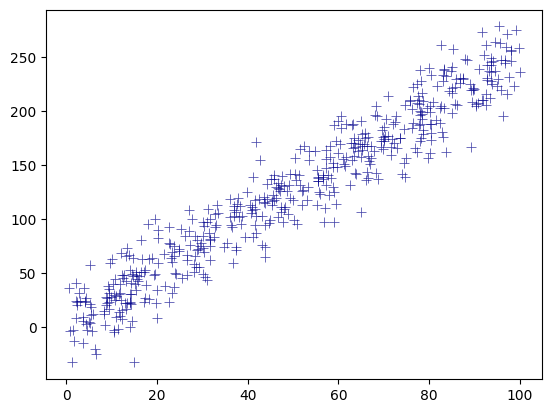

In [7]:
n_samples = 500
start = 0
end = 100

k = 2.5
b = 3
X = rng.uniform(start, end, size=n_samples)
noise = rng.normal(size=n_samples) * (end-start) / 5

# make simple line and add some noise
y = k * X + b + noise
sns.scatterplot(x=X, y=y, s=50, color="darkblue", alpha=0.7, marker="+")

X = X.reshape(n_samples, 1)
X_train, X_test, X_val, y_train, y_test, y_val = preprocess_data(X, y)

w, b = gradient_descent(
        X_train, 
        y_train, 
        X_test=X_test,
        y_test=y_test,
        X_val=X_val,
        y_val=y_val,
        epochs=100,
        learning_rate=1e-4,
        l2_reg_penalty = 0.1
    )

model weights=[2.15709806], bias=(0.7811599768503207)
[ 0.54298341 99.91047305] [  1.95242844 216.29784758]


<Axes: >

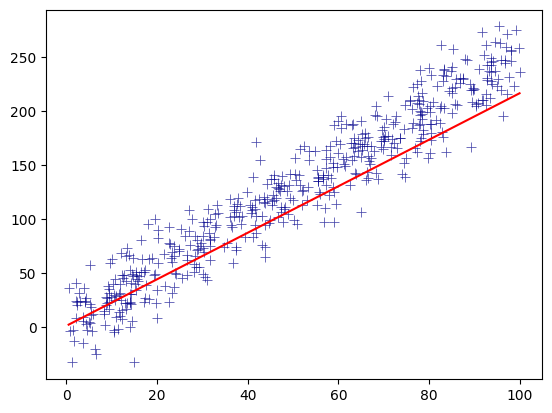

In [8]:
linear_regression = LinearRegression(n_fractors=1, weights=w, bias=b)
print(f'model weights={w}, bias=({b})')

x_line = np.array([min(X), max(X)]).flatten()
y_line = linear_regression(x_line)
print(x_line, y_line)

sns.lineplot(x=x_line, y=y_line, color='red')
# X = X.reshape((n_samples, -1))

sns.scatterplot(x=X.flatten(), y=y, s=50, color="darkblue", alpha=0.7, marker="+")

### Подготовка датасета 

In [9]:
df = pd.read_csv('../data/car_price/car_price.csv')
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [10]:
df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

Удалим столбец `'car_id'`, который не будет никак влиять на обучение моделей и предсказание цены.
Нам также вероятно не понадобятся столбец `'CarName'`

In [11]:
df = df.drop("car_ID", axis=1)
df = df.drop("CarName", axis=1)
df.head(3)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0


In [12]:
df_missed = df[df.isna().any(axis=1)]
df_missed.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price


Видим, что в датасете нет пропущенных значений. 

Построим гистаграммы значений признаков

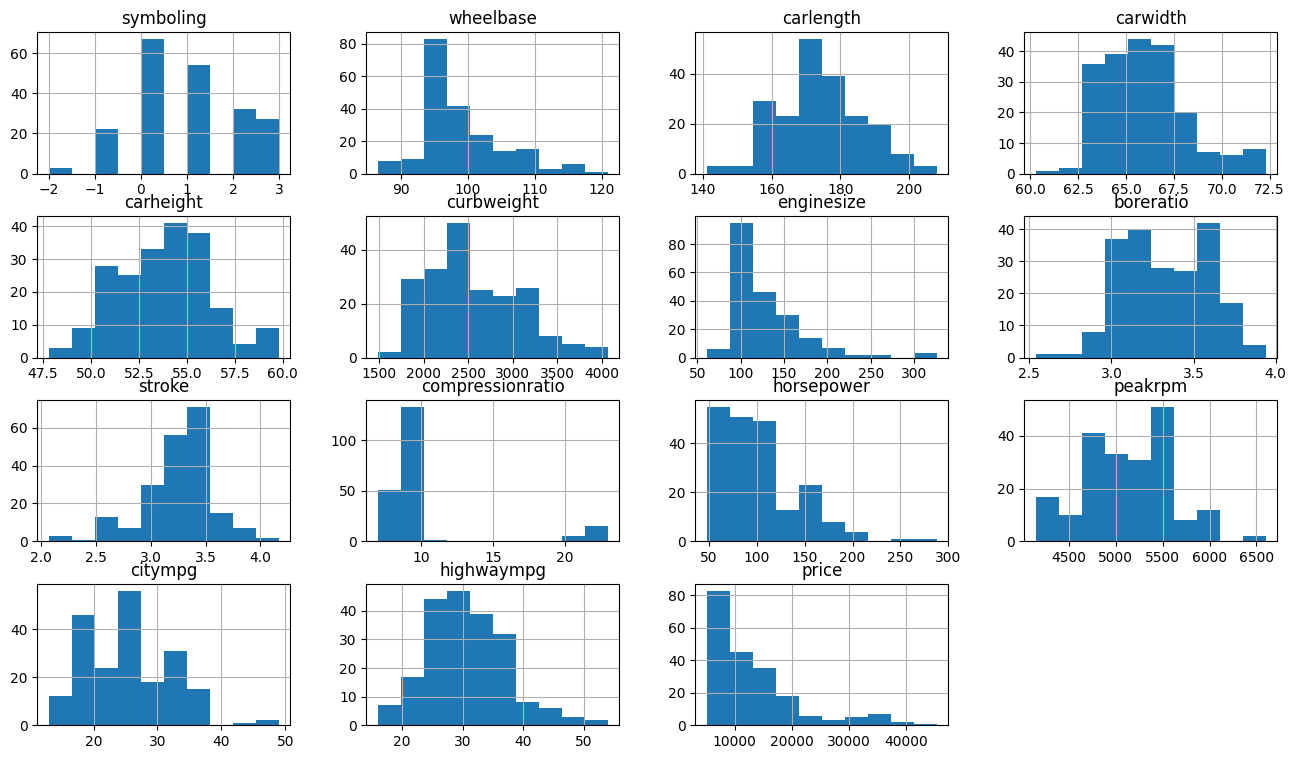

In [13]:
df.hist(figsize=(16,9))
plt.show()

Посчитаем корреляции для числовых признаков

In [14]:
df.corr(numeric_only=True).sort_values(by='price', ascending=False)['price']

price               1.000000
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
symboling          -0.079978
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

Мы видим, что хорошая корреляция количеством лошадиных сил `'horsepower'`, размере двигателя `'enginesize'`, весе `'curbweight'`, 
длине и ширине, а также у показателей эффективности топливного расхода `'horsepower'` `'citympg'`

Заметим, что `'horsepower'` `'citympg'` обозначают практически одно и то же, поэтому возьмем что-то одно. Например `'highwaympg'`

Итого, признаки, которые мы возьмем для обучения модели:
- enginesize
- curbweight
- horsepower
- carwidth
- carlength
- highwaympg

Таким образом, можно составить таблицу признаков, которые нам интересны:


In [15]:
good_features = df[['enginesize', 'curbweight', 'horsepower', 'carwidth', 'carlength', 'highwaympg', 'price']]
good_features

,enginesize,curbweight,horsepower,carwidth,carlength,highwaympg,price
0,130,2548,111,64.1,168.8,27,13495.0
1,130,2548,111,64.1,168.8,27,16500.0
2,152,2823,154,65.5,171.2,26,16500.0
3,109,2337,102,66.2,176.6,30,13950.0
4,136,2824,115,66.4,176.6,22,17450.0
...,...,...,...,...,...,...,...
200,141,2952,114,68.9,188.8,28,16845.0
201,141,3049,160,68.8,188.8,25,19045.0
202,173,3012,134,68.9,188.8,23,21485.0
203,145,3217,106,68.9,188.8,27,22470.0


Преобразуем данные в numpy-массив:

In [16]:
X = good_features.iloc[:, :-1].to_numpy()
y = good_features.iloc[:, -1].to_numpy()

print('First five samples:')
X[:5], y[:5]

First five samples:


(array([[ 130. , 2548. ,  111. ,   64.1,  168.8,   27. ],
        [ 130. , 2548. ,  111. ,   64.1,  168.8,   27. ],
        [ 152. , 2823. ,  154. ,   65.5,  171.2,   26. ],
        [ 109. , 2337. ,  102. ,   66.2,  176.6,   30. ],
        [ 136. , 2824. ,  115. ,   66.4,  176.6,   22. ]]),
 array([13495., 16500., 16500., 13950., 17450.]))

**Отмасштабируем данные** с помощью модуля preprocessing в sklearn.

Будем использовать `StandardScaler()`, который производит [z-нормализацию](https://wiki.loginom.ru/articles/data-normalization.html#normalizatsiya-srednim-z-normalizatsiya).

In [17]:
features_scaler = preprocessing.StandardScaler().fit(X)
X = features_scaler.transform(X)

y = y.reshape(-1, 1)
price_scaler = preprocessing.StandardScaler().fit(y)
y = price_scaler.transform(y)

print('First five samples:')
X[:5], y[:5]

First five samples:


(array([[ 0.07444893, -0.01456628,  0.17448278, -0.84478235, -0.42652147,
         -0.54605874],
        [ 0.07444893, -0.01456628,  0.17448278, -0.84478235, -0.42652147,
         -0.54605874],
        [ 0.60404617,  0.51488192,  1.26453643, -0.19056612, -0.23151305,
         -0.69162706],
        [-0.43107572, -0.42079745, -0.05366798,  0.13654199,  0.2072559 ,
         -0.10935377],
        [ 0.21888454,  0.51680718,  0.27588312,  0.23000146,  0.2072559 ,
         -1.27390036]]),
 array([[0.02739114],
        [0.4044611 ],
        [0.4044611 ],
        [0.08448493],
        [0.52366791]]))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train length:", len(X_train))
print("X_test length:", len(X_test))

X_train length: 164
X_test length: 41


In [19]:
print(f'{X_train.shape=}')
print(f'{y_train.shape=}')

X_train.shape=(164, 6)
y_train.shape=(164, 1)


Теперь можно обучить модель на выборке.

В качестве валидационной выборки будем использовать тестовую выборку.

In [20]:
w, b = gradient_descent(
    X_train,
    y_train,
    X_test=X_test, 
    y_test=y_test,
    X_val=X_test, 
    y_val=y_test,
    epochs=10_000,
    learning_rate = 1e-4,
    loss_fun=mse_loss,
    l2_reg_penalty=0.4,
    verbose=1,
    print_n_epochs=1000
)
print('Model coeffs w, f=', w, b)

Initial weights of the model: [-0.54955262 -1.12276843 -1.18412833  0.08650554  0.32700987 -0.79252583], bias:0.02658534132609864
Dataset size: train=164, val=41, test=41
learning_rate=0.0001, epochs=10000
Epoch 0: train loss: 4.203396472108029, val. loss: 4.022787087494499
Epoch 1000: train loss: 2.1753067547628926, val. loss: 2.083601265140358
Epoch 2000: train loss: 1.6377283121369213, val. loss: 1.8559575481040687
Epoch 3000: train loss: 1.5960562666769758, val. loss: 2.1128460821645643
Epoch 4000: train loss: 1.6846957816763672, val. loss: 2.430585693971456
Epoch 5000: train loss: 1.7808612379879436, val. loss: 2.686147167559463
Epoch 6000: train loss: 1.8515479959337164, val. loss: 2.861368516794175
Epoch 7000: train loss: 1.8942647139679498, val. loss: 2.9693267065188014
Epoch 8000: train loss: 1.9149870932879627, val. loss: 3.0284093128140372
Epoch 9000: train loss: 1.920573514455661, val. loss: 3.0544064355942826
test loss: 3.0590085122130324, train. loss: 1.916598574391968
Mo

Посчитаем значения метрик $MSE\:$,  $RMSE\:$ и  $R^2$:

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

lin_reg = LinearRegression(n_fractors=6, weights=w, bias=b)
y_test_pred = lin_reg(X_test)

print(f'MSE =', mean_squared_error(y_test_pred, y_test))
print(f'RMSE =', root_mean_squared_error(y_test_pred, y_test))
print(f'R2 =', r2_score(y_test_pred, y_test))

MSE = 1.0480138745524559
RMSE = 1.0237254878884554
R2 = 0.41769563202707305


Может показаться странным, что значения MSE, которые считаются в `gradient_descent` 
и значение функции из sklearn, не совпадают. Однако надо вспомнить, что мы используем L2 регуляризацию, 
которая добавляет сумму квадратов весов модели. 

Попробуем посчитать mse_loss, реализованную выше, мы получим:

In [22]:
print(f'my MSE =', mse_loss(y_test_pred, y_test))

my MSE = 3.0590085122130324


Да уж!  Кажется я ошибся в своих выводах, не знаю где у меня здесь ошбика, но значения явно расходятся :) Мелочь, а неприятно.

Обучим модель Ridge.

In [23]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.4)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
print(f"MSE (Ridge): {mean_squared_error(y_test, y_pred_ridge)}")
print(f'RMSE (Ridge): {root_mean_squared_error(y_test, y_pred_ridge)}')
print(f'R2 (Ridge): {r2_score(y_test, y_pred_ridge)}')

MSE (Ridge): 0.22861575264042988
RMSE (Ridge): 0.4781377967076331
R2 (Ridge): 0.8160787106510043


Видим, что полученные значения нашей модели гораздо хуже.


In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores 
avg_mse_ridge = mse_scores.mean()
print(f"Cross-Validated Mean Squared Error (Ridge): {avg_mse_ridge}")

Cross-Validated Mean Squared Error (Ridge): 0.26805468080590217
